In [1]:
!pip install opencv-python numpy matplotlib scipy netCDF4 ipywidgets


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


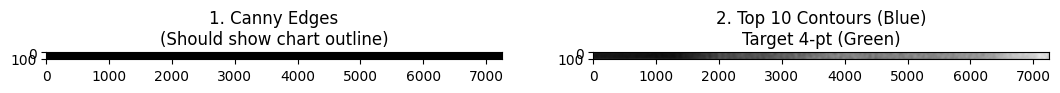

FAILED: No 4-point rectangle found. Try adjusting Canny thresholds.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator, interp1d
from scipy.signal import savgol_filter
import glob
import os
import pandas as pd

# --- Configuration ---
#np.array([
#    0, 9, 18, 28, 37, 47, 56, 66, 75, 85, 94, 103,
#    113, 122, 132, 141, 151, 160, 170, 179, 188,
#    198, 207, 217, 226, 236, 245, 255
#])
output_range = 80
INPUT_LABELS = np.arange(255)

# Folder containing your test photos
IMAGE_DIR = '/content/'
EXTENSIONS = ['*.jpg', '*.jpeg', '*.PNG', '*.bmp']

# %%
# --- Configuration ---
# ROI Settings (Percentages 0.0 - 1.0)
# ROI Settings (Percentages 0.0 - 1.0)
# ROI_Y_GRAD_MIN, ROI_Y_GRAD_MAX = 0.20, 0.40  # Continuous Gradient Height
# ROI_Y_STEP_MIN, ROI_Y_STEP_MAX = 0.60, 0.80  # Stepped Gradient Height

# # NEW: Horizontal Margins (Cut off left/right edges)
# # Adjust these if your photo has white borders or background on the sides
# ROI_X_MIN = 0.029  # Start 2% from the left
# ROI_X_MAX = 0.97  # End 2% from the right (cuts off 2%)

# The specific labels for this chart
CHART_LABELS = np.arange(68)

import cv2
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

def get_roi_vars_with_perspective_v2(file_path, debug=True):
    # 1. LOAD DATA
    if file_path.lower().endswith('.nc'):
        ds = nc.Dataset(file_path)
        var_name = next((k for k in ds.variables if ds.variables[k].ndim >= 2), None)
        data = ds.variables[var_name][:]
        if data.ndim == 3: data = data[0, :, :]
        # Normalize to 8-bit for CV2
        img_gray = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        img_bgr = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
        ds.close()
    else:
        img_bgr = cv2.imread(file_path)

    if img_bgr is None: return "File Load Error"

    # 2. PRE-PROCESSING (The "Vision" part)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Adaptive thresholding often works better for scientific data than Canny
    edged = cv2.Canny(blurred, 110, 150)

    # 3. CONTOUR DETECTION
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Sort by area
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    screen_cnt = None
    all_cnts_img = img_bgr.copy()
    cv2.drawContours(all_cnts_img, contours, -1, (255, 0, 0), 2) # Draw top 10 in Blue

    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            screen_cnt = approx
            break

    # 4. DIAGNOSTICS - STAGE 1 (Finding the Chart)
    if debug:
        plt.figure(figsize=(20, 10))

        plt.subplot(2, 3, 1)
        plt.title("1. Canny Edges\n(Should show chart outline)")
        plt.imshow(edged, cmap='gray')

        plt.subplot(2, 3, 2)
        plt.title("2. Top 10 Contours (Blue)\nTarget 4-pt (Green)")
        if screen_cnt is not None:
            cv2.drawContours(all_cnts_img, [screen_cnt], -1, (0, 255, 0), 5)
        plt.imshow(cv2.cvtColor(all_cnts_img, cv2.COLOR_BGR2RGB))

    if screen_cnt is None:
        plt.show()
        print("FAILED: No 4-point rectangle found. Try adjusting Canny thresholds.")
        return None

    # 5. PERSPECTIVE WARP
    pts = screen_cnt.reshape(4, 2)
    rect = order_points(pts) # Using order_points from previous code
    (tl, tr, br, bl) = rect

    # Draw ordered points for debug
    points_img = img_bgr.copy()
    for i, p in enumerate(rect):
        cv2.circle(points_img, (int(p[0]), int(p[1])), 10, (0, 0, 255), -1)
        cv2.putText(points_img, str(i), (int(p[0]), int(p[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    max_width = int(max(np.linalg.norm(br-bl), np.linalg.norm(tr-tl)))
    max_height = int(max(np.linalg.norm(tr-br), np.linalg.norm(tl-bl)))
    dst = np.array([[0,0], [max_width-1, 0], [max_width-1, max_height-1], [0, max_height-1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img_bgr, M, (max_width, max_height))

    # 6. INTERNAL ANALYSIS (Finding bars inside warped image)
    warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(warped_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 5))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # DIAGNOSTICS - STAGE 2 (Processing the Warp)
    if debug:
        plt.subplot(2, 3, 3)
        plt.title("3. Corner Order\n(0=TL, 1=TR, 2=BR, 3=BL)")
        plt.imshow(cv2.cvtColor(points_img, cv2.COLOR_BGR2RGB))

        plt.subplot(2, 3, 4)
        plt.title("4. Warped Image")
        plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

        plt.subplot(2, 3, 5)
        plt.title("5. Morph Mask\n(Should isolate bars)")
        plt.imshow(morph, cmap='gray')

    # Final ROI calculation
    cnts, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bar_boxes = sorted([cv2.boundingRect(c) for c in cnts if cv2.boundingRect(c)[2] > max_width*0.4], key=lambda b: b[1])

    if len(bar_boxes) >= 2:
        res_img = warped.copy()
        cv2.rectangle(res_img, (bar_boxes[0][0], bar_boxes[0][1]), (bar_boxes[0][0]+bar_boxes[0][2], bar_boxes[0][1]+bar_boxes[0][3]), (0,0,255), 3)
        cv2.rectangle(res_img, (bar_boxes[-1][0], bar_boxes[-1][1]), (bar_boxes[-1][0]+bar_boxes[-1][2], bar_boxes[-1][1]+bar_boxes[-1][3]), (255,0,0), 3)

        if debug:
            plt.subplot(2, 3, 6)
            plt.title("6. Final Bar Detection")
            plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))
            plt.tight_layout()
            plt.show()

        return {
            "ROI_Y_GRAD_MIN": round(bar_boxes[0][1]/max_height, 3),
            "ROI_Y_GRAD_MAX": round((bar_boxes[0][1]+bar_boxes[0][3])/max_height, 3),
            "ROI_Y_STEP_MIN": round(bar_boxes[-1][1]/max_height, 3),
            "ROI_Y_STEP_MAX": round((bar_boxes[-1][1]+bar_boxes[-1][3])/max_height, 3),
            "ROI_X_MIN": round(bar_boxes[0][0]/max_width, 3),
            "ROI_X_MAX": round((bar_boxes[0][0]+bar_boxes[0][2])/max_width, 3)
        }
    else:
        plt.show()
        print("FAILED: Could not find two distinct bars in the warped image.")
        return None

# Helper to order points
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)] # TL
    rect[2] = pts[np.argmax(s)] # BR
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)] # TR
    rect[3] = pts[np.argmax(diff)] # BL
    return rect
# --- Execute ---
photo_path = "../posters/scan.PNG"
roi_vars = get_roi_vars_with_perspective_v2(photo_path, debug=True)

if roi_vars:
    print("\nDetected Configuration Variables:")
    for k, v in roi_vars.items():
        print(f"{k} = {v}")

In [3]:
import cv2
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatRangeSlider, VBox, HBox, Label

# --- 1. LOAD DATA ---
def load_data(file_path):
    if file_path.lower().endswith('.nc'):
        ds = nc.Dataset(file_path)
        var_name = next((k for k in ds.variables if ds.variables[k].ndim >= 2), None)
        data = ds.variables[var_name][:]
        if data.ndim == 3: data = data[0, :, :]
        img = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        ds.close()
        return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img = cv2.imread(file_path)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

FILE_PATH = "../posters/scan.PNG"
IMG = load_data(FILE_PATH)
H, W, _ = IMG.shape

# --- 2. INTERACTIVE TUNER ---
def manual_roi_tuner(grad_y, step_y, x_range):
    tmp = IMG.copy()

    # Calculate pixel coordinates from percentages (sliders use 0-100 for ease)
    gy1, gy2 = int(grad_y[0]*H/100), int(grad_y[1]*H/100)
    sy1, sy2 = int(step_y[0]*H/100), int(step_y[1]*H/100)
    x1, x2 = int(x_range[0]*W/100), int(x_range[1]*W/100)

    # Draw ROIs
    # Red for Smooth Gradient, Blue for Stepped Gradient
    cv2.rectangle(tmp, (x1, gy1), (x2, gy2), (255, 0, 0), 4)
    cv2.rectangle(tmp, (x1, sy1), (x2, sy2), (0, 0, 255), 4)

    plt.figure(figsize=(15, 8))
    plt.imshow(tmp)
    plt.title("Manual ROI Selection (Red: Smooth, Blue: Stepped)")
    plt.axis('off')
    plt.show()

    ROI_X_MIN = x_range[0]/100
    ROI_X_MAX = x_range[1]/100
    ROI_Y_GRAD_MIN = grad_y[0]/100
    ROI_Y_GRAD_MAX = grad_y[1]/100
    ROI_Y_STEP_MIN = step_y[0]/100
    ROI_Y_STEP_MAX = step_y[1]/100

    # Print the code block for the user to copy
    print("-" * 30)
    print("COPY THESE SETTINGS TO YOUR CONFIG:")
    print(f"ROI_X_MIN = {x_range[0]/100:.3f}")
    print(f"ROI_X_MAX = {x_range[1]/100:.3f}")
    print(f"ROI_Y_GRAD_MIN = {grad_y[0]/100:.3f}")
    print(f"ROI_Y_GRAD_MAX = {grad_y[1]/100:.3f}")
    print(f"ROI_Y_STEP_MIN = {step_y[0]/100:.3f}")
    print(f"ROI_Y_STEP_MAX = {step_y[1]/100:.3f}")
    print("-" * 30)

# Create Sliders
grad_y_slider = FloatRangeSlider(value=[20, 40], min=0, max=100, step=0.1, description='Smooth Y %')
step_y_slider = FloatRangeSlider(value=[60, 80], min=0, max=100, step=0.1, description='Step Y %')
x_slider = FloatRangeSlider(value=[5, 95], min=0, max=100, step=0.1, description='X Range %')

# Display UI
interact(manual_roi_tuner, grad_y=grad_y_slider, step_y=step_y_slider, x_range=x_slider);

interactive(children=(FloatRangeSlider(value=(20.0, 40.0), description='Smooth Y %'), FloatRangeSlider(value=(…

✅ Calibration image detected: ../posters/scan.png
Scaling data to output_range: 255


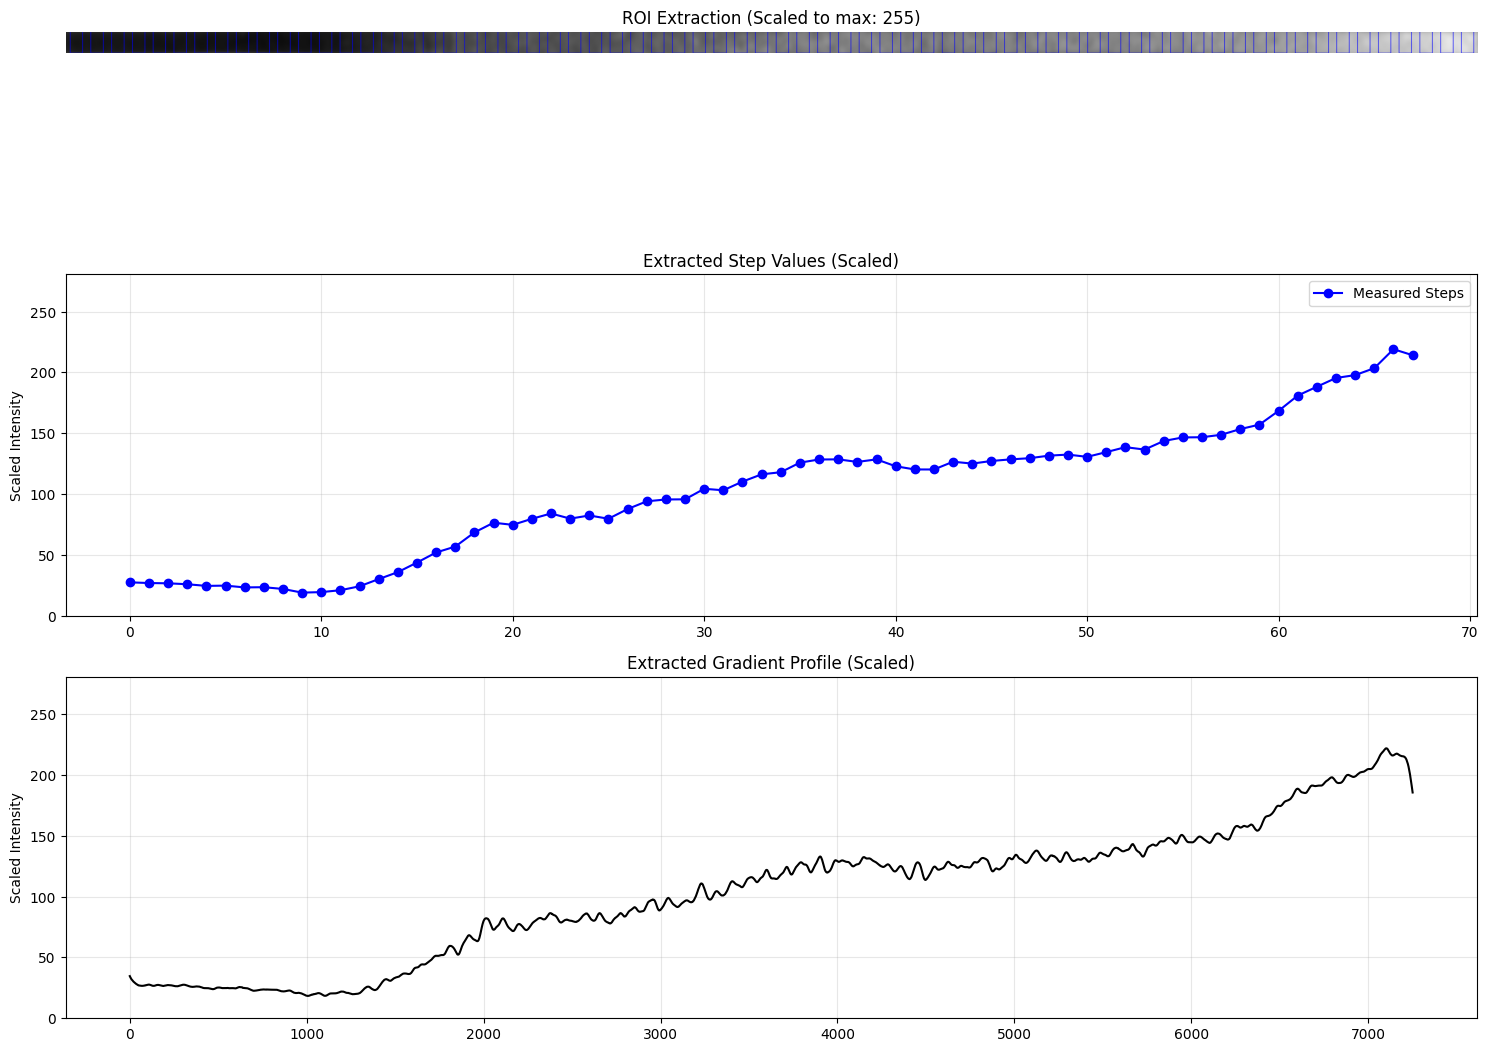

Extraction Complete!
First 3 steps (scaled to 67): [27.515625   26.9527027  26.72057995]
Gradient profile length: 7252


In [4]:
def extract_calibration_data(image_path):
    ROI_X_MIN = 0.00
    ROI_X_MAX = 1
    ROI_Y_GRAD_MIN = 0
    ROI_Y_GRAD_MAX = 1
    ROI_Y_STEP_MIN = 0
    ROI_Y_STEP_MAX = 1
    global INPUT_LABELS
    # Ensure output_range is accessible (assuming it is defined in a previous cell)
    # If not defined yet, we'll default to 255 for safety
    target_max = 255

    # 1. Check if Image Exists
    if not os.path.exists(image_path):
        print(f"⚠️ Calibration image '{image_path}' not found.")
        return None, None

    # 2. Override Global Labels
    print(f"✅ Calibration image detected: {image_path}")
    print(f"Scaling data to output_range: {target_max}")
    INPUT_LABELS = CHART_LABELS

    # 3. Load Image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Failed to read image data.")
        return None, None

    # Convert to Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape

    # 4. Calculate ROI Coordinates (Pixels)
    grad_y1, grad_y2 = int(h * ROI_Y_GRAD_MIN), int(h * ROI_Y_GRAD_MAX)
    step_y1, step_y2 = int(h * ROI_Y_STEP_MIN), int(h * ROI_Y_STEP_MAX)
    x_start_global, x_end_global = int(w * ROI_X_MIN), int(w * ROI_X_MAX)

    # 5. Extract Strips
    grad_strip = gray[grad_y1:grad_y2, x_start_global:x_end_global]
    step_strip = gray[step_y1:step_y2, x_start_global:x_end_global]
    cropped_w = step_strip.shape[1]

    # 6. Extract Stepped Values
    measured_steps = []
    num_steps = len(INPUT_LABELS)
    step_width = cropped_w / num_steps

    debug_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    for i in range(num_steps):
        margin = step_width * 0.2
        x_rel_start = int((i * step_width) + margin)
        x_rel_end = int(((i + 1) * step_width) - margin)

        patch = step_strip[:, x_rel_start:x_rel_end]

        # --- SCALING LOGIC ---
        # Normalize (0-1) and then scale to output_range
        mean_val_raw = np.mean(patch)
        scaled_val = (mean_val_raw / 255.0) * target_max
        measured_steps.append(scaled_val)

        global_x1 = x_start_global + x_rel_start
        global_x2 = x_start_global + x_rel_end
        cv2.rectangle(debug_img, (global_x1, step_y1), (global_x2, step_y2), (0, 0, 255), 2)

    # 7. Extract Gradient Profile & Scale
    # Get the horizontal mean across the strip
    grad_profile_raw = np.mean(grad_strip, axis=0)
    measured_gradient = (grad_profile_raw / 255.0) * target_max

    # --- Plotting Results ---
    plt.figure(figsize=(15, 12))

    # Plot 1: Image Overlay
    plt.subplot(3, 1, 1)
    plt.imshow(debug_img)
    plt.title(f"ROI Extraction (Scaled to max: {target_max})")
    plt.axis('off')

    # Plot 2: Steps
    plt.subplot(3, 1, 2)
    plt.plot(INPUT_LABELS, measured_steps, 'bo-', label='Measured Steps')
    plt.ylabel("Scaled Intensity")
    plt.ylim(0, target_max * 1.1) # Set limit slightly above target max
    plt.title("Extracted Step Values (Scaled)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 3: Gradient
    plt.subplot(3, 1, 3)
    plt.plot(measured_gradient, 'k-', label='Continuous Gradient')
    plt.ylabel("Scaled Intensity")
    plt.ylim(0, target_max * 1.1)
    plt.title("Extracted Gradient Profile (Scaled)")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return np.array(measured_steps), measured_gradient
# Provide the path to your image (JPG, PNG, or .nc)
path_to_image = "../posters/scan.png"

# Call the function and catch the two return values
steps_data, gradient_data = extract_calibration_data(path_to_image)

# Verify the results
if steps_data is not None:
    print(f"Extraction Complete!")
    print(f"First 3 steps (scaled to {67}):", steps_data[:3])
    print(f"Gradient profile length:", len(gradient_data))
else:
    print("Extraction failed. Check the error messages above.")

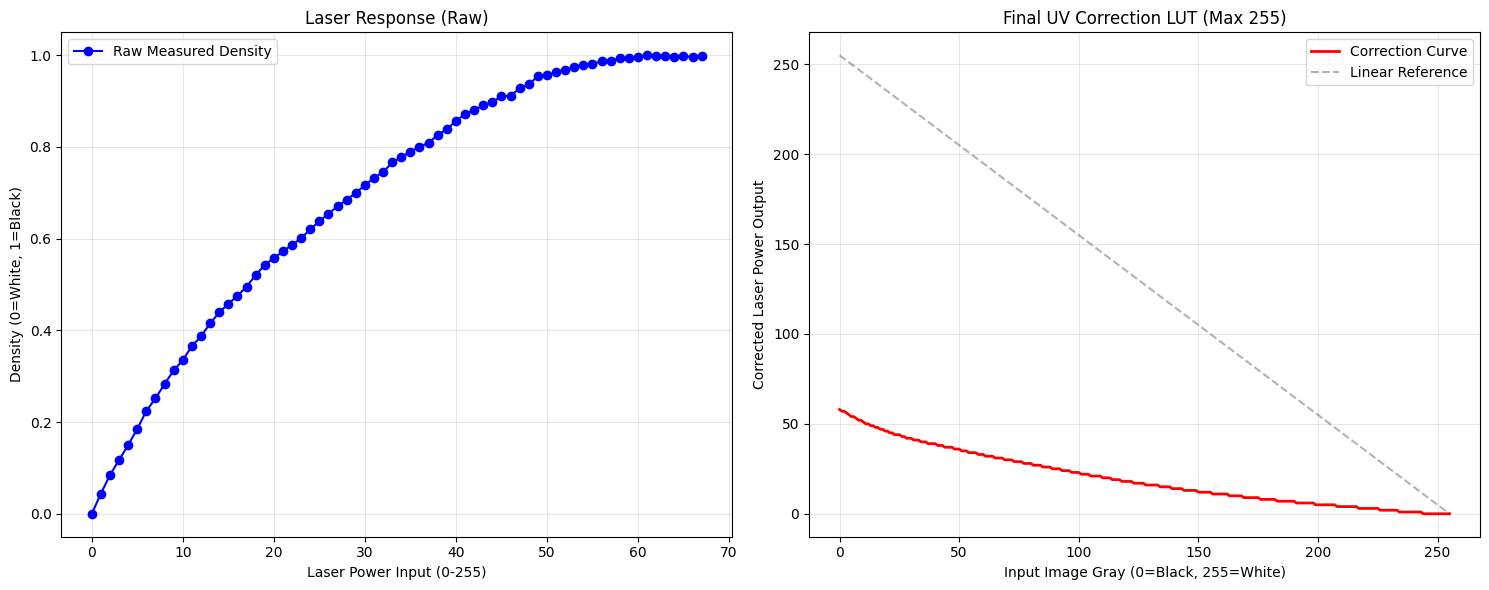

✅ LUT Generated and saved to 'uv_laser_correction_raw.csv'


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import sparse
from scipy.sparse.linalg import spsolve
import pandas as pd

def create_correction_lut(measured_steps, input_labels, max_output=255, lmbd=5000):
    """
    Generates a correction LUT for a UV Laser based on raw measurements.
    """

    # --- 1. Data Preparation & Sorting ---
    inputs = np.array(input_labels)
    measures = np.array(measured_steps)

    sorted_indices = np.argsort(inputs)
    x_power = inputs[sorted_indices]
    y_measure = measures[sorted_indices]

    # --- 2. Calculate Relative Density ---
    # Scanner: High Value (e.g. 240) = White/Paper
    # Scanner: Low Value (e.g. 20) = Black/Burn
    p_paper = np.max(y_measure)
    p_black = np.min(y_measure)
    p_range = p_paper - p_black

    if p_range < 5:
        print("Warning: Low contrast detected.")
        p_range = 1.0

    # Normalize: 0.0 = Paper (White), 1.0 = Max Density (Black)
    density = (p_paper - y_measure) / p_range
    density = np.clip(density, 0, 1)

    # --- 3. Create Inverse Mapping ---
    # Use raw density directly (removed monotonic enforcement loop)
    # We add tiny noise (epsilon) only to ensure the interpolation math doesn't
    # crash if two measured densities are identical.
    epsilon = 1e-6 * np.arange(len(density))

    f_interp = interp1d(
        density + epsilon,
        x_power,
        kind='linear',
        fill_value="extrapolate"
    )

    # Generate targets for standard image (0=Black, 255=White)
    # Image Value 0 (Black)   -> Target Density 1.0
    # Image Value 255 (White) -> Target Density 0.0
    target_densities = np.linspace(1.0, 0.0, 256)
    raw_lut = f_interp(target_densities)

    # --- 4. Whittaker-Eilers Smoothing ---
    # This handles the noise/fluctuations from the raw measurement
    m = len(raw_lut)
    d = np.diff(np.eye(m), 2)
    D = sparse.csr_matrix(d)
    K = D.dot(D.transpose())
    W = sparse.spdiags(np.ones(m), 0, m, m)
    A = W + lmbd * K
    final_lut = spsolve(A, raw_lut)

    # --- 5. Final Formatting ---
    final_lut = np.clip(final_lut, 0, max_output).astype(int)

    # Ensure pure white (255) turns laser OFF (0)
    final_lut[255] = 0

    return final_lut, density, raw_lut, x_power

# --- Execute and Plot ---

# 1. Define your test chart settings
#INPUT_LABELS = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 255]
# 2. Define your scanner measurements (High=White, Low=Black)
# Note: I've included a "non-monotonic" dip at power 180 to demonstrate the change
MEASURED_STEPS = [255, 255, 250, 200, 150, 100, 60, 40, 20, 35, 10, 5]

MAX_POWER = 255

correction_lut, raw_density, raw_unsmoothed, sorted_powers = create_correction_lut(
    gradient_data, INPUT_LABELS, max_output=MAX_POWER, lmbd=2000
)

# --- Visualization ---
plt.figure(figsize=(15, 6))

# Plot A: The Measured Response (Now shows raw fluctuations)
plt.subplot(1, 2, 1)
plt.plot(sorted_powers, raw_density, 'b-o', label='Raw Measured Density')
plt.title("Laser Response (Raw)")
plt.xlabel(f"Laser Power Input (0-{MAX_POWER})")
plt.ylabel("Density (0=White, 1=Black)")
plt.grid(True, alpha=0.3)
plt.legend()

# Plot B: The Correction LUT
plt.subplot(1, 2, 2)
plt.plot(correction_lut, 'r-', linewidth=2, label='Correction Curve')
plt.plot([0, 255], [MAX_POWER, 0], 'k--', alpha=0.3, label='Linear Reference')
plt.title(f"Final UV Correction LUT (Max {MAX_POWER})")
plt.xlabel("Input Image Gray (0=Black, 255=White)")
plt.ylabel("Corrected Laser Power Output")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Save to CSV
df_lut = pd.DataFrame({'Index': np.arange(256), 'Value': correction_lut})
df_lut.to_csv('uv_laser_correction_raw.csv', index=False)
print(f"✅ LUT Generated and saved to 'uv_laser_correction_raw.csv'")

✅ CSV saved to: uv_laser_correction_inverted.csv
   Input 0   (Black Pixel) -> Output Power 255
   Input 255 (White Pixel) -> Output Power 0


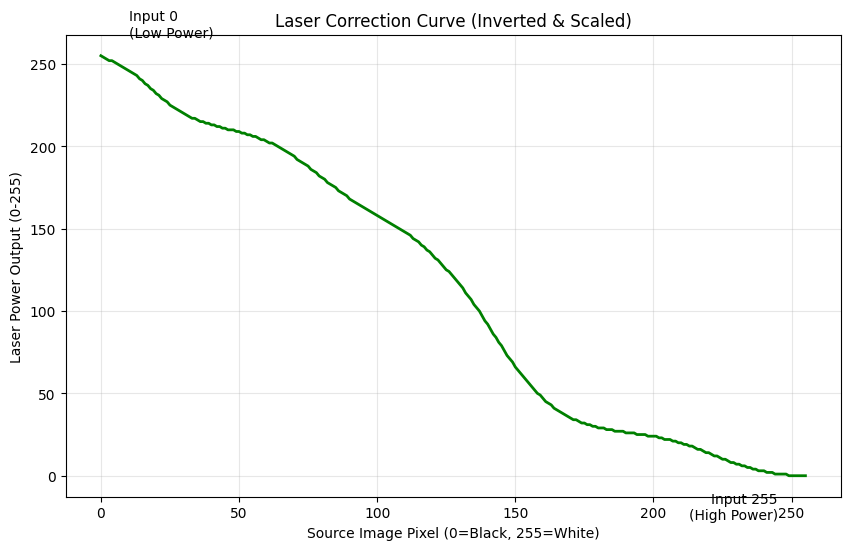

In [6]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

def generate_inverted_scaled_lut(data, filename='laser_correction_inverted.csv', lmbd=5000):

    # --- 1. Map Data to Physical Laser Power ---
    max_physical_power = 255
    x_power = np.linspace(0, max_physical_power, len(data))
    y_measure = np.array(data, dtype=float)

    # --- 2. Calculate Density ---
    p_paper = np.max(y_measure)
    p_black = np.min(y_measure)
    p_range = p_paper - p_black

    if p_range < 1:
        p_range = 1.0

    # 0.0 = Paper, 1.0 = Max Density
    density = (p_paper - y_measure) / p_range
    density = np.clip(density, 0, 1)

    # --- 3. Create Inverse Mapping (Density -> Power) ---
    sort_idx = np.argsort(density)
    density_sorted = density[sort_idx]
    power_sorted = x_power[sort_idx]

    epsilon = 1e-6 * np.arange(len(density_sorted))

    f_interp = interp1d(
        density_sorted + epsilon,
        power_sorted,
        kind='linear',
        fill_value="extrapolate"
    )

    # --- 4. Generate Initial LUT ---
    # We maintain standard image logic here first
    # 0 (Black) -> Needs Density 1.0
    # 255 (White) -> Needs Density 0.0
    target_densities = np.linspace(1.0, 0.0, 256)
    raw_lut_values = f_interp(target_densities)

    # --- 5. Smoothing ---
    m = len(raw_lut_values)
    d = np.diff(np.eye(m), 2)
    D = sparse.csr_matrix(d)
    K = D.dot(D.transpose())
    W = sparse.spdiags(np.ones(m), 0, m, m)
    A = W + lmbd * K

    smoothed_output = spsolve(A, raw_lut_values)

    # --- 6. Scale and INVERT ---
    # First, normalize to 0-255 range
    curr_min = smoothed_output.min()
    curr_max = smoothed_output.max()

    if (curr_max - curr_min) == 0:
        scaled_output = smoothed_output
    else:
        scaled_output = (smoothed_output - curr_min) / (curr_max - curr_min) * 255

    # Clip to standard range
    scaled_output = np.clip(scaled_output, 0, 255)

    # *** THE INVERSION STEP ***
    # Flip the values: 0 becomes 255, 255 becomes 0
    final_output_power = 255 - scaled_output

    # Convert to integer
    final_output_power = final_output_power.astype(int)

    # --- 7. Save to CSV ---
    df = pd.DataFrame({
        'Input': np.arange(256),     # Source Image Pixel
        'Output': final_output_power # Laser Power
    })

    df.to_csv(filename, index=False)

    return df, final_output_power

# --- EXECUTION ---

if 'gradient_data' in locals() or 'gradient_data' in globals():

    # Run the generation
    csv_file = 'uv_laser_correction_inverted.csv'
    df_result, lut_array = generate_inverted_scaled_lut(gradient_data, filename=csv_file, lmbd=5000)

    print(f"✅ CSV saved to: {csv_file}")
    print(f"   Input 0   (Black Pixel) -> Output Power {df_result['Output'][0]}")
    print(f"   Input 255 (White Pixel) -> Output Power {df_result['Output'][255]}")

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(df_result['Input'], df_result['Output'], color='green', linewidth=2)
    plt.title("Laser Correction Curve (Inverted & Scaled)")
    plt.xlabel("Source Image Pixel (0=Black, 255=White)")
    plt.ylabel("Laser Power Output (0-255)")
    plt.grid(True, alpha=0.3)

    # Helper text to confirm direction
    plt.text(10, df_result['Output'][0] + 10, "Input 0\n(Low Power)", verticalalignment='bottom')
    plt.text(245, df_result['Output'][255] - 10, "Input 255\n(High Power)", horizontalalignment='right', verticalalignment='top')

    plt.show()

else:
    print("❌ Error: 'gradient_data' variable not found.")

✅ CSV saved to: uv_laser_correction_gamma.csv
   Gamma Used: 2.2
   Input 0   (Black Pixel) -> Output Power 228
   Input 128 (Mid Pixel)   -> Output Power 202
   Input 255 (White Pixel) -> Output Power 0


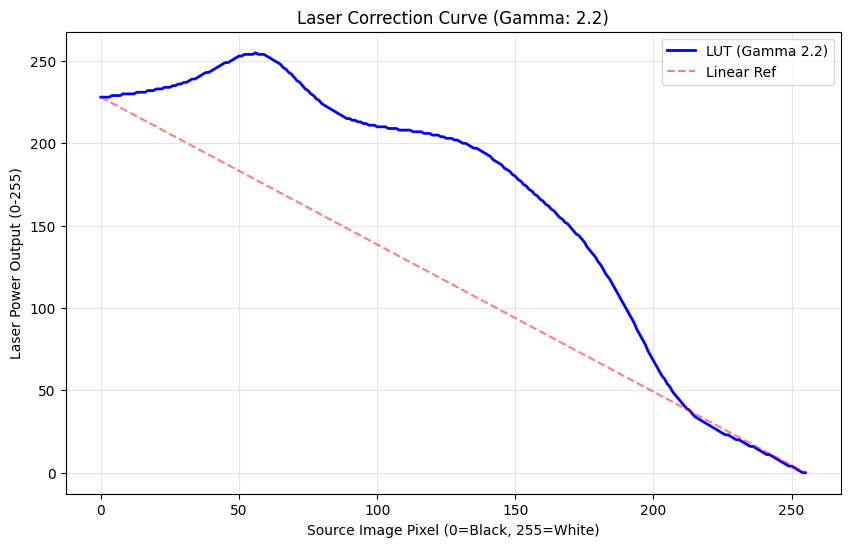

In [7]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

def generate_inverted_scaled_lut(data, filename='laser_correction_inverted.csv', lmbd=5000, gamma=1.0):
    """
    Generates a laser power LUT with Smoothing and Gamma Correction.

    Parameters:
    - data: List/Array of measurement values.
    - filename: Output CSV name.
    - lmbd: Smoothing factor (Whittaker-Eilers).
    - gamma: Gamma correction value.
             1.0 = Linear
             >1.0 = Darker Midtones (Curves up)
             <1.0 = Lighter Midtones (Curves down)
    """

    # --- 1. Map Data to Physical Laser Power ---
    max_physical_power = 255
    x_power = np.linspace(0, max_physical_power, len(data))
    y_measure = np.array(data, dtype=float)

    # --- 2. Calculate Density ---
    # Assuming lower measurement value = darker mark (absorption) or vice versa depending on sensor.
    # Standard: High Value = Paper (White), Low Value = Burnt (Black)
    p_paper = np.max(y_measure)
    p_black = np.min(y_measure)
    p_range = p_paper - p_black

    if p_range < 1:
        p_range = 1.0

    # Normalize Density: 0.0 = Paper (White), 1.0 = Max Density (Black)
    density = (p_paper - y_measure) / p_range
    density = np.clip(density, 0, 1)

    # --- 3. Create Inverse Mapping (Density -> Power) ---
    # We need to find what Power is required to achieve a specific Density
    sort_idx = np.argsort(density)
    density_sorted = density[sort_idx]
    power_sorted = x_power[sort_idx]

    # Add epsilon to prevent duplicate x-values for interpolation
    epsilon = 1e-6 * np.arange(len(density_sorted))

    f_interp = interp1d(
        density_sorted + epsilon,
        power_sorted,
        kind='linear',
        fill_value="extrapolate"
    )

    # --- 4. Generate Initial LUT with GAMMA CORRECTION ---
    # Create normalized input range (0=Black/Start, 1=White/End)
    # Note: In standard 8-bit, 0 is usually black.

    # 1. Create Linear Input (0.0 to 1.0)
    input_intensity = np.linspace(0, 1, 256)

    # 2. Apply Gamma Correction
    # Formula: Output = Input ^ Gamma
    input_corrected = np.power(input_intensity, gamma)

    # 3. Map to Target Density
    # Input 0 (Black) -> Needs Density 1.0
    # Input 1 (White) -> Needs Density 0.0
    target_densities = 1.0 - input_corrected

    # 4. Get required raw power for these densities
    raw_lut_values = f_interp(target_densities)

    # --- 5. Smoothing (Whittaker-Eilers) ---
    m = len(raw_lut_values)
    d = np.diff(np.eye(m), 2)
    D = sparse.csr_matrix(d)
    K = D.dot(D.transpose())
    W = sparse.spdiags(np.ones(m), 0, m, m)
    A = W + lmbd * K

    smoothed_output = spsolve(A, raw_lut_values)

    # --- 6. Scale and INVERT ---
    # First, normalize to 0-255 range based on the smoothed curve
    curr_min = smoothed_output.min()
    curr_max = smoothed_output.max()

    if (curr_max - curr_min) == 0:
        scaled_output = smoothed_output
    else:
        scaled_output = (smoothed_output - curr_min) / (curr_max - curr_min) * 255

    # Clip to standard range
    scaled_output = np.clip(scaled_output, 0, 255)

    # *** THE INVERSION STEP ***
    # This flips the result so it matches the specific controller requirement
    # (0 becomes 255, 255 becomes 0)
    final_output_power = 255 - scaled_output

    # Convert to integer
    final_output_power = final_output_power.astype(int)

    # --- 7. Save to CSV ---
    df = pd.DataFrame({
        'Input': np.arange(256),     # Source Image Pixel
        'Output': final_output_power # Laser Power
    })

    df.to_csv(filename, index=False)

    return df, final_output_power

# --- EXECUTION ---

# Mock data for testing if 'gradient_data' isn't provided externally
if 'gradient_data' not in locals() and 'gradient_data' not in globals():
    print("⚠️ 'gradient_data' not found. Creating dummy data for demonstration.")
    # Create a dummy curve that mimics a laser becoming effective only after 20% power
    x_dummy = np.linspace(0, 255, 100)
    # Simulating: High value (255) is white paper, Low value (50) is black burn
    # Laser doesn't burn until power > 50, then burns rapidly
    y_dummy = 255 - (np.maximum(0, x_dummy - 50) * 1.2)
    y_dummy = np.clip(y_dummy, 50, 255)
    gradient_data = y_dummy

if 'gradient_data' in locals() or 'gradient_data' in globals():

    # SETTINGS
    output_filename = 'uv_laser_correction_gamma.csv'
    smoothing_lambda = 5000
    target_gamma = 2.2 # Change this: 1.0=Linear, 2.2=Standard CRT/sRGB, 0.8=Lighter

    # Run the generation
    df_result, lut_array = generate_inverted_scaled_lut(
        gradient_data,
        filename=output_filename,
        lmbd=smoothing_lambda,
        gamma=target_gamma
    )

    print(f"✅ CSV saved to: {output_filename}")
    print(f"   Gamma Used: {target_gamma}")
    print(f"   Input 0   (Black Pixel) -> Output Power {df_result['Output'][0]}")
    print(f"   Input 128 (Mid Pixel)   -> Output Power {df_result['Output'][128]}")
    print(f"   Input 255 (White Pixel) -> Output Power {df_result['Output'][255]}")

    # Visualization
    plt.figure(figsize=(10, 6))

    # Plot the calculated LUT
    plt.plot(df_result['Input'], df_result['Output'], color='blue', linewidth=2, label=f'LUT (Gamma {target_gamma})')

    # Plot a reference linear line for comparison
    plt.plot([0, 255], [df_result['Output'][0], df_result['Output'][255]], color='red', linestyle='--', alpha=0.5, label='Linear Ref')

    plt.title(f"Laser Correction Curve (Gamma: {target_gamma})")
    plt.xlabel("Source Image Pixel (0=Black, 255=White)")
    plt.ylabel("Laser Power Output (0-255)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

else:
    print("❌ Error: 'gradient_data' variable not found.")

✅ LUT Generated.
   Input 0 (Black) -> Output Power 0 (Should be High)
   Input 255 (White) -> Output Power 255 (Should be Low)


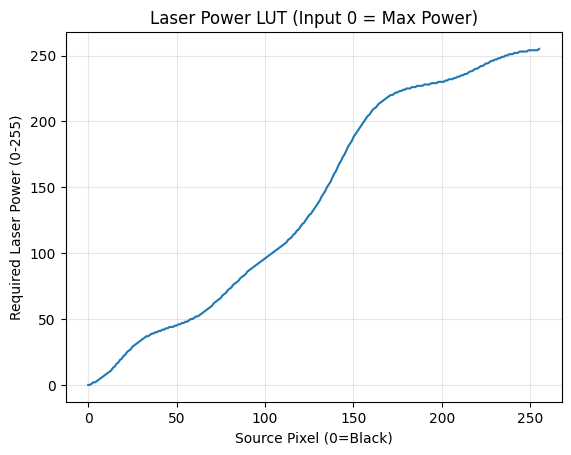

In [8]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

def generate_inverted_scaled_lut(data, filename='laser_correction.csv', lmbd=5000, gamma=1.0):

    # --- 1. Map Data to Physical Laser Power ---
    # Assuming the gradient test was printed with:
    # 0 = Min Power, 255 = Max Power
    max_physical_power = 255
    x_power = np.linspace(0, max_physical_power, len(data))
    y_measure = np.array(data, dtype=float)

    # --- 2. Calculate Density ---
    # High Measurement = Paper (White/Low Density)
    # Low Measurement = Burnt (Black/High Density)
    p_paper = np.max(y_measure)
    p_black = np.min(y_measure)
    p_range = p_paper - p_black
    if p_range < 1: p_range = 1.0

    # 0.0 = Paper, 1.0 = Max Density
    density = (p_paper - y_measure) / p_range
    density = np.clip(density, 0, 1)

    # --- 3. Create Inverse Mapping (Density -> Power) ---
    sort_idx = np.argsort(density)
    density_sorted = density[sort_idx]
    power_sorted = x_power[sort_idx]

    # Epsilon to prevent interpolation errors
    epsilon = 1e-6 * np.arange(len(density_sorted))

    f_interp = interp1d(
        density_sorted + epsilon,
        power_sorted,
        kind='linear',
        fill_value="extrapolate"
    )

    # --- 4. Logic: Input Pixel vs Target Density ---
    # Input 0   (Black Pixel) -> Needs Density 1.0 (Max)
    # Input 255 (White Pixel) -> Needs Density 0.0 (Min)

    # Normalized Input (0.0 to 1.0)
    # Input 0.0 represents Black Pixel
    input_norm = np.linspace(0, 1, 256)

    # Gamma Correction
    # If Gamma > 1 (e.g. 2.2), Mid-tones become darker (closer to density 1.0)
    # Since Input 0 is our Max Density source, we apply gamma to the 'whiteness'
    # 0 = Black, 1 = White.
    # To curve towards Black, we act on the inversion.
    input_corrected = np.power(input_norm, gamma)

    # Map to Target Density
    # Input 0 (Black) -> input_corrected 0 -> Density 1.0
    # Input 1 (White) -> input_corrected 1 -> Density 0.0
    target_densities = 1.0 - input_corrected

    # Get Raw Power needed for these densities
    raw_lut_values = f_interp(target_densities)

    # --- 5. Smoothing ---
    m = len(raw_lut_values)
    d = np.diff(np.eye(m), 2)
    D = sparse.csr_matrix(d)
    K = D.dot(D.transpose())
    W = sparse.spdiags(np.ones(m), 0, m, m)
    A = W + lmbd * K
    smoothed_output = spsolve(A, raw_lut_values)

    # --- 6. Final Scaling ---
    # Normalize the smoothed curve to utilize full 0-255 hardware range
    curr_min = smoothed_output.min()
    curr_max = smoothed_output.max()

    if (curr_max - curr_min) == 0:
        scaled_output = smoothed_output
    else:
        scaled_output = (smoothed_output - curr_min) / (curr_max - curr_min) * 255

    scaled_output = np.clip(scaled_output, 0, 255)

    # NO INVERSION HERE.
    # Input 0 is Black, which resulted in Density 1.0, which requires High Power.
    # So index 0 of this array will be ~255.
    final_output_power = scaled_output.astype(int)

    # --- 7. Save ---
    df = pd.DataFrame({
        'Input': np.arange(256),
        'Output': final_output_power
    })
    df.to_csv(filename, index=False)

    return df, final_output_power

# --- EXECUTION BLOCK ---
if 'gradient_data' in locals() or 'gradient_data' in globals():
    df_res, _ = generate_inverted_scaled_lut(
        gradient_data,
        filename='laser_correction.csv',
        lmbd=5000,
        gamma=1.0
    )

    print("✅ LUT Generated.")
    print(f"   Input 0 (Black) -> Output Power {df_res['Output'][0]} (Should be High)")
    print(f"   Input 255 (White) -> Output Power {df_res['Output'][255]} (Should be Low)")

    plt.plot(df_res['Input'], df_res['Output'])
    plt.title("Laser Power LUT (Input 0 = Max Power)")
    plt.xlabel("Source Pixel (0=Black)")
    plt.ylabel("Required Laser Power (0-255)")
    plt.grid(True, alpha=0.3)
    plt.show()

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# 1. Setup path and search for all .csv files in ./content
path = '/content/'
csv_files = sorted(glob.glob(os.path.join(path, "*.csv")))

if not csv_files:
    print(f"No CSV files found in {path}. Please check the directory path.")
else:
    plt.figure(figsize=(10, 6))

    for file in csv_files:
        # Get the filename without extension for the legend label
        label = os.path.basename(file).replace('.csv', '')

        try:
            # 2. Load the CSV
            # header=None if your LUTs don't have column names
            df = pd.read_csv(file)

            # 3. Plot the data
            # This plots all columns in the file against the index
            # If your LUT has specific x/y columns, use: plt.plot(df['input'], df['output'])
            plt.plot(df['Input'], df['Output'], label=label)
            #plt.plot(df, label=label)

        except Exception as e:
            print(f"Could not plot {file}: {e}")

    # 4. Formatting the graph
    plt.title('CSV LUT Comparison')
    plt.xlabel('Input / Index')
    plt.ylabel('Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside to avoid overlap
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

No CSV files found in /content/. Please check the directory path.


Normalizing data and calculating Refined LUT...
✅ Saved updated LUT to: laser_correction_v2.csv


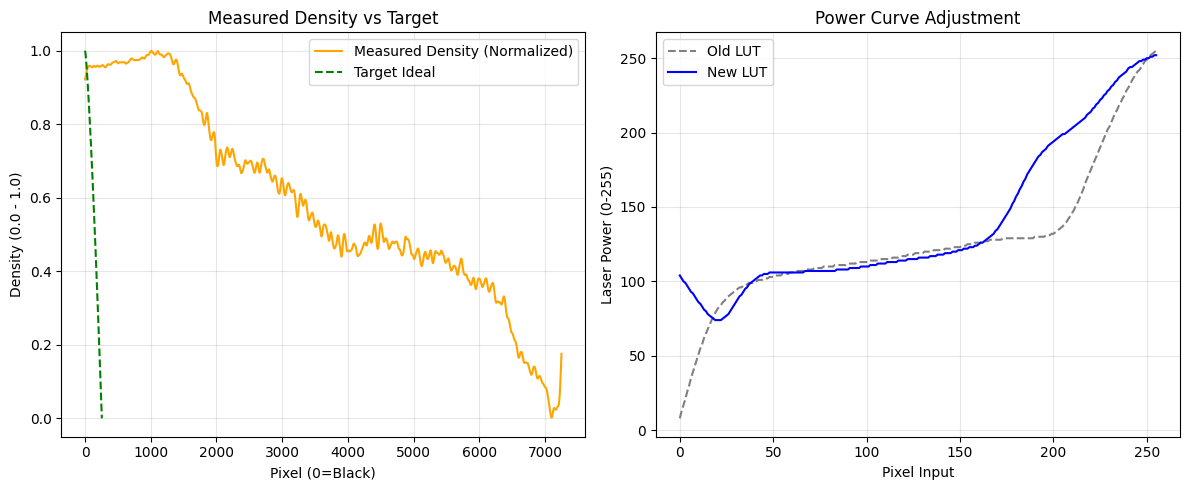

In [10]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

def whittaker_smooth(data, lmbd=5000):
    """ Smoothing function to handle sensor noise """
    m = len(data)
    d = np.diff(np.eye(m), 2)
    D = sparse.csr_matrix(d)
    K = D.dot(D.transpose())
    W = sparse.spdiags(np.ones(m), 0, m, m)
    A = W + lmbd * K
    return spsolve(A, data)

def refine_correction_lut(
    measurement_data,
    old_lut_csv,
    new_lut_filename='laser_correction_v2.csv',
    lmbd=5000,
    gamma=1.0
):
    """
    Creates a refined LUT based on the error of a previous print.
    Normalizes input measurement data to 0-255 before processing.
    """

    # --- 1. Load the Old LUT (Power Map) ---
    try:
        df_old = pd.read_csv(old_lut_csv)
        # Assuming columns ['Input', 'Output']
        old_power_curve = df_old['Output'].values

        # Function: Input Pixel (0-255) -> Laser Power (0-255)
        f_old_power = interp1d(
            np.linspace(0, 255, len(old_power_curve)),
            old_power_curve,
            kind='linear',
            fill_value="extrapolate"
        )
    except Exception as e:
        print(f"❌ Error loading old LUT: {e}")
        return None, None, None

    # --- 2. Process Measured Data ---
    y_raw = np.array(measurement_data, dtype=float)

    # *** ADDED: Normalize Raw Data to 0-255 ***
    y_min = np.min(y_raw)
    y_max = np.max(y_raw)

    if (y_max - y_min) == 0:
        # Avoid divide by zero if data is a flat line
        y_measure = np.zeros_like(y_raw)
    else:
        # Scale to 0-255
        y_measure = (y_raw - y_min) / (y_max - y_min) * 255.0

    x_pixels = np.linspace(0, 255, len(y_measure))

    # --- 3. Calculate Density ---
    # Assuming Standard Reflectance Sensor:
    # High Value (255) = White Paper
    # Low Value (0) = Black Mark
    p_paper = np.max(y_measure)
    p_black = np.min(y_measure)
    p_range = p_paper - p_black

    if p_range < 1: p_range = 1.0

    # Calculate Density (0.0 = White, 1.0 = Black)
    # The (p_paper - y_measure) flips the logic so Low Sensor Value = High Density
    raw_density = (p_paper - y_measure) / p_range
    raw_density = np.clip(raw_density, 0, 1)

    # Smooth the Density
    measured_density = whittaker_smooth(raw_density, lmbd=lmbd)

    # --- 4. Create Inverse Mapping: Measured Density -> Input Pixel ---
    # We identify: "At which pixel x in the previous image did we achieve Density D?"

    # Sort for valid interpolation (Density usually increases as Pixel value decreases)
    # Note: In our Logic, Pixel 0 = Black (High Density), Pixel 255 = White (Low Density)
    # So we expect high density at low x.
    sort_idx = np.argsort(measured_density)
    sorted_density = measured_density[sort_idx]
    sorted_pixels = x_pixels[sort_idx]

    epsilon = 1e-6 * np.arange(len(sorted_density))

    f_density_to_pixel = interp1d(
        sorted_density + epsilon,
        sorted_pixels,
        kind='linear',
        fill_value=(sorted_pixels[0], sorted_pixels[-1]),
        bounds_error=False
    )

    # --- 5. Calculate New Powers ---
    inputs = np.arange(256)
    new_powers = []

    # For visualization of target
    target_curve_y = []

    for i in inputs:
        # A. Determine Target Density
        # Input 0 (Black) -> Target 1.0
        # Input 255 (White) -> Target 0.0

        norm_i = i / 255.0 # 0..1

        # Apply Gamma correction to the intensity curve
        # (Standard logic: Gamma acts on the "Lightness")
        adjusted_val = np.power(norm_i, gamma)

        # Invert to get Density
        target_density = 1.0 - adjusted_val
        target_curve_y.append(target_density)

        # B. Find the effective pixel from the previous run
        # "To get Target Density X, we need the power previously found at Pixel Y"
        effective_pixel = f_density_to_pixel(target_density)

        # C. Get the power used at that pixel
        corrected_power = f_old_power(effective_pixel)

        new_powers.append(corrected_power)

    new_powers = np.array(new_powers)
    new_powers =  whittaker_smooth(new_powers, lmbd=lmbd)

    # --- 6. Save ---
    # Ensure range 0-255 and integer
    new_powers = np.clip(new_powers, 0, 255).astype(int)

    df_new = pd.DataFrame({
        'Input': inputs,
        'Output': new_powers
    })
    df_new.to_csv(new_lut_filename, index=False)

    return df_new, measured_density, target_curve_y

# --- EXECUTION ---

# Define files
previous_lut_file = '..\luts\interpolated_output.csv'
new_lut_file = 'laser_correction_v2.csv'

if 'gradient_data' in locals() or 'gradient_data' in globals():

    # Settings
    gamma_val = 1.3


    print("Normalizing data and calculating Refined LUT...")
    df_v2, measured_d, target_d = refine_correction_lut(
        gradient_data,
        previous_lut_file,
        new_lut_file,
        lmbd=2000,
        gamma=gamma_val
    )

    if df_v2 is not None:
        print(f"✅ Saved updated LUT to: {new_lut_file}")

        # Visualization
        plt.figure(figsize=(12, 5))

        # Plot 1: Density
        plt.subplot(1, 2, 1)
        plt.plot(measured_d, label='Measured Density (Normalized)', color='orange')
        plt.plot(target_d, '--', label='Target Ideal', color='green')
        plt.title("Measured Density vs Target")
        plt.xlabel("Pixel (0=Black)")
        plt.ylabel("Density (0.0 - 1.0)")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 2: LUT Change
        plt.subplot(1, 2, 2)
        try:
            df_old = pd.read_csv(previous_lut_file)
            plt.plot(df_old['Input'], df_old['Output'], '--', label='Old LUT', color='gray')
            plt.plot(df_v2['Input'], df_v2['Output'], label='New LUT', color='blue')
        except:
            pass

        plt.title("Power Curve Adjustment")
        plt.xlabel("Pixel Input")
        plt.ylabel("Laser Power (0-255)")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

else:
    print("❌ Error: 'gradient_data' variable not found.")

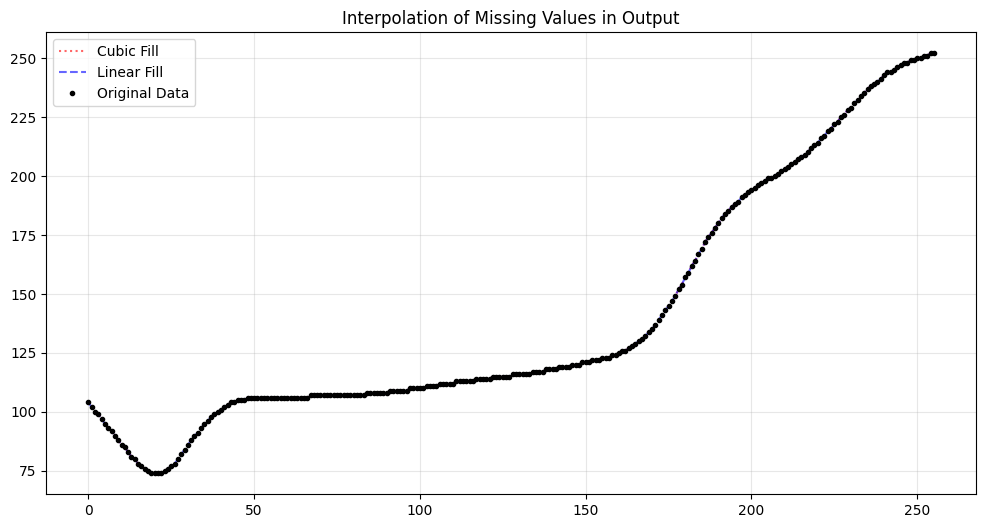

Sample of the data:
    Output  interp_linear  interp_cubic
0      104            104           104
1      102            102           102
2      100            100           100
3       99             99            99
4       97             97            97
5       95             95            95
6       93             93            93
7       92             92            92
8       90             90            90
9       88             88            88
10      86             86            86
11      85             85            85
12      83             83            83
13      81             81            81
14      80             80            80
15      78             78            78
16      77             77            77
17      76             76            76
18      75             75            75
19      74             74            74
20      74             74            74
21      74             74            74
22      74             74            74
23      75          

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
file_path = 'laser_correction_v2.csv'   # Replace with your CSV filename
col_name = 'Output'     # Replace with the name of the column with missing values

# 1. Load the CSV
df = pd.read_csv(file_path)

# (Optional: Simulate missing values to test the code if your data is already full)
# df.loc[10:20, col_name] = np.nan

# 2. Interpolate Missing Values
# Method A: Linear (Draws a straight line between existing points - safest)
df['interp_linear'] = df[col_name].interpolate(method='linear', limit_direction='both')

# Method B: Cubic (Draws a smooth curve - better for waves/signals)
# Note: Cubic can sometimes overshoot (go below 0 or above 255), so we clip it.
df['interp_cubic'] = df[col_name].interpolate(method='cubic', limit_direction='both')

# 3. Constraint: Ensure 0-255 range and Integer type
# We clip bounds, round to nearest whole number, and convert to integer
df['interp_linear'] = df['interp_linear'].clip(0, 255).round().astype(int)
df['interp_cubic'] = df['interp_cubic'].clip(0, 255).round().astype(int) # Handle cubic overshoot

# 4. Visualize
plt.figure(figsize=(12, 6))

# Plot the "Filled" data first (so it sits behind the real data points)
plt.plot(df['interp_cubic'], color='red', linestyle=':', label='Cubic Fill', alpha=0.6)
plt.plot(df['interp_linear'], color='blue', linestyle='--', label='Linear Fill', alpha=0.6)

# Plot the Original data (dots only) to show where real data exists
plt.plot(df[col_name], 'o', color='black', markersize=3, label='Original Data')

plt.title(f'Interpolation of Missing Values in {col_name}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Save the result (using Linear or Cubic)
df[col_name] = df['interp_cubic'] # Overwrite original column if satisfied
df.to_csv('interpolated_output.csv', index=False)

# Check the results where data was likely missing
print("Sample of the data:")
print(df[[col_name, 'interp_linear', 'interp_cubic']].head(25))

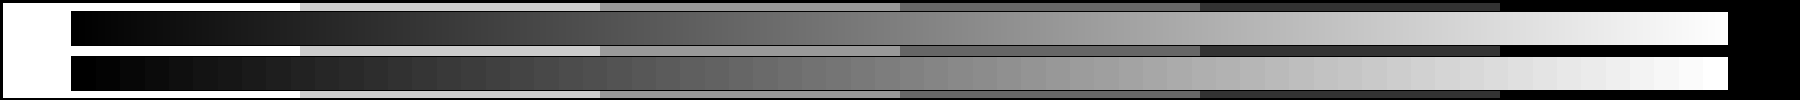

Image saved as grayscale_calibration.png


In [12]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

# --- CONFIGURATION ---
MIN_VAL = 0
MAX_VAL = 255     # Your requested range end
NUM_STEPS = 68   # How many blocks in the bottom bar
WIDTH = 1800     # Image width in pixels
HEIGHT = 100     # Image height in pixels
OUTPUT_FILE = "grayscale_calibration.png"

def create_calibration_chart(v_min, v_max, steps, width, height):
    # Create a grayscale image (L mode)
    # Using a dark gray background base
    img = Image.new('L', (width, height), color=30)
    draw = ImageDraw.Draw(img)

    # 1. Draw the 6 Background Vertical Bands
    # These provide context for different brightness levels
    band_width = width // 6
    for i in range(6):
        # Scale background bands across the full 0-255 range for visual style
        bg_color = 255 - int((i / 5) * 255) # Inverted for better contrast
        draw.rectangle([i * band_width, 0, (i + 1) * band_width, height], fill=bg_color)

    # Padding and bar dimensions
    pad_x = width // 25
    pad_y = height // 8
    bar_h = height // 3
    bar_w = width - (2 * pad_x)

    # 2. Top Bar: Smooth Gradient
    # We create a 1D array from v_min to v_max and stretch it
    top_bar_y1 = pad_y
    top_bar_y2 = pad_y + bar_h
    gradient = np.linspace(v_min, v_max, bar_w).astype(np.uint8)
    gradient_tile = np.tile(gradient, (bar_h, 1))
    grad_img = Image.fromarray(gradient_tile, mode='L')
    img.paste(grad_img, (pad_x, top_bar_y1))

    #We subtract/add 1 to make the frame sit exactly on the outside edge
    draw.rectangle([pad_x - 1, top_bar_y1 - 1, pad_x + bar_w, top_bar_y2], outline=0, width=1)

    # 3. Bottom Bar: Stepped Gradient & Labels
    bottom_bar_y1 = top_bar_y2 + (pad_y )
    bottom_bar_y2 = bottom_bar_y1 + bar_h

    step_vals = np.linspace(v_min, v_max, steps).astype(np.uint8)
    block_w = bar_w / steps

    # Try to load a font, fallback to default (Not used currently, but kept for future use)
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except:
        font = ImageFont.load_default()

    for i, val in enumerate(step_vals):
        x1 = int(pad_x + i * block_w)
        x2 = int(pad_x + (i + 1) * block_w)

        # Draw the discrete block
        draw.rectangle([x1, bottom_bar_y1, x2, bottom_bar_y2], fill=int(val))

        # (Original label drawing code commented out as it was in the initial prompt)
        # Draw the Label
        #label = str(val)
        # Calculate text position (centered under block)
        # Determine text color based on background band (inverse-ish)
        #text_color = 255 if (x1 + block_w/2) < width/2 else 0
        # Drawing text slightly below the bar
        #draw.text((x1 + (block_w/2) - 5, bottom_bar_y2 + 5), label, fill=text_color, font=font)
    # --- 1-PIXEL FRAME FOR BOTTOM BAR ---
    draw.rectangle([pad_x - 1, bottom_bar_y1 - 1, pad_x + bar_w, bottom_bar_y2], outline=0, width=1)

    # --- ADD THE 2-PIXEL WIDE FRAME ---
    frame_thickness = 2
    frame_color = 0 # Black color for the frame

    # Top border
    draw.rectangle([0, 0, width, frame_thickness], fill=frame_color)
    # Bottom border
    draw.rectangle([0, height - frame_thickness, width, height], fill=frame_color)
    # Left border
    draw.rectangle([0, 0, frame_thickness, height], fill=frame_color)
    # Right border
    draw.rectangle([width - frame_thickness, 0, width, height], fill=frame_color)
    # --- END FRAME ADDITION ---

    return img

# Execute and save
calibration_img = create_calibration_chart(MIN_VAL, MAX_VAL, NUM_STEPS, WIDTH, HEIGHT)
calibration_img.save(OUTPUT_FILE, dpi=(300, 300))
display(calibration_img) # Displays in Jupyter
print(f"Image saved as {OUTPUT_FILE}")